> https://www.kaggle.com/startupsci/titanic-data-science-solutions

# Titanic问题的数据挖掘步骤
## 首先介绍 Data Science Solutions书中处理的步骤


1. 问题定义
2. 构建训练集和测试集数据
3. 准备和清洗数据
4. 分析数据，识别特征模式
5. 建模，预测并解决问题
6. 可视化报告最终的方案
7. 提交结果


- 步骤可以打乱穿插

# 1. 问题定义

来自Kaggle竞赛Titanic的介绍：
> 已知训练集和测试集，训练集中是891个人的个人信息和是否存活，测试集中是个人信息，要求使用训练集训练我们的模型，判断测试集中的人是否存活

一些需要知道的背景知识：
- 1912年4月15日，Titanic首次航行撞冰山沉没2224个乘客中1505个丧生，存活率为32%
- 没有足够的救生船是死亡率这么高的一个原因
- 即使有一些幸运的成分，但是有些群体更容易存活，比如说女人、小孩和上层阶层

# 2. 解决流程
- **Classifying**：对样本进行归类，不同类之间的相关性进行分析
- **Correlating**：可以通过训练集现有的特征来解决问题。在这个数据集下，哪个特征对结果有贡献？从统计角度看特征和结果有什么相关性？改变特征值结果会不会变？这些可以在给定的数据集中计算。我们也可能需要确定结果和后续目标之间的相关性。特征相关性可以帮助构造特征，缺失值补全和纠错。
- **Converting**：在建模阶段，需要准备数据。和模型算法有关，有的需要把所有特征的值都转化为数值型的。因此需要把文本数据或者序号数据都转换成数值性。
- **Completing**：缺失值补全。
- **Correcting**：分析给定数据集中错误或者不准确的值，并改正或者直接删除异常样本。一个方法是检测样本或者特征的异常。如果一个特征对结果没有贡献，可以删除这个特征。
- **Creating**：根据一个或者一组特征构造新特征，依据是相关性、变换或者使目标完整。
- **Charting**：根据数据和解决目标来选择图表。

# 导包

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# 导入数据

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

# 通过数据描述来分析
## 数据集中有哪些特征？

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


## 类别特征
把样本分成几个相似样本的集合。这些特征的值可以是名字、序数、百分比、按间隔划分。这个可以帮助我们选择合适的图进行可视化。
- Survived, Sex, and Embarked. Ordinal: Pclass

## 数值特征
每个样本的值基本不同，非连续的、连续的、基于时间序列的。
- Age, Fare. Discrete: SibSp, Parch

In [4]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 混合类型的特征
在同一个特征中存在数值型和数字字母型值。一般都是需要纠错的。
- Ticket是数值型和数字字母型的混合， Cabin是数字字母型的

## 包含错误的特征
大数据集很难来预览，小数据可以方便的预览一些样本来看哪些是需要纠错的。
- Name特征可能有错笔误，所以可以提取头衔、圆括号和引号作为 替代，或者短名来纠错

In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## 特征的缺失处理
- Cabin > Age > Embarked ，训练集中缺失的数量排序
- Cabin > Age 测试集中的缺失

## 不同特征的数据类型
可以帮助我们转换数据
- 7个特征是整型或者浮点型，测试集中有6个
- 5个特征是字符串型

In [6]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## 样本中连续样本的分布
这有助于我们确定除了其他早期见解之外，实际问题领域的培训数据集的代表性如何。

- 总共891个样本，占Titanic样本(2224)中的41%
- Survived 是一个0-1的类别特征
- 样本中存活率为38%，实际是32%
- 大多数乘客（75%）没有父母和小孩在船上
- 大约30%的乘客有兄弟或者配偶在船上
- 只有小于1%的乘客的船费大于512美元
- 35-80岁的乘客小于1%

In [7]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 类别特征的分布

- Name在数据集中的每一个值都是唯一的(count=unique=891)
- Sex变量有两个可能的值，male占65%(top=male, freq=577/count=891)
- Cabin有一些样本的值是一样的，可能是有一些乘客共用一个船舱
- Embarked有3个值，大多数乘客都是S(top=S)
- Ticket有22%的重复率(unique=681)

In [8]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## 根据数据分析的假设
基于前面的数据分析做一些假设，可能会在后面进行验证

- Correlating
  1. 我们需要知道各个特征和结果的相关关系。先在工程中做一下，然后在模型中计算一下。
- Completing
  1. 根据和存活率的相关性来补全Age缺失值
  2. 根据和存活率或者其他重要特征的相关性来补全Embarked缺失值
- Correcting
  1. Ticket要删掉，因为重复率22%，而且和存活特征相关性小
  2. Cabin要删掉，因为训练集和测试集的缺失值太多
  3. PassengerId要删掉，因为对存活结果没有贡献
  4. Name特征不怎么标准，和存活没有直接关联，要删除
- Creating
  1. 用船上配偶和子女的数量（Parch和SibSp）的和构造家人数量（Family）特征
  2. 在Name特征中提取头衔Title作为一个特征
  3. 把Age特征按区间划分，从连续的数值型转化为类别特征
  4. 把Fare按区间划分帮助分析
- Classifying
基于问题的描述增加一些假设
  1. Women(Sex=female)更容易存活
  2. Children (Age<?)更容易存活
  3. The upper-class passengers (Pclass=1)更容易存活

## 转化特征来进行分析
为了验证我们的观察和假设，通过转化特征来进行一个快速的特征分析。只能对不缺失的特征进行分析。只对categorical类别 (Sex), ordinal序数 (Pclass) or discrete不连续 (SibSp, Parch)的特征进行操作才有意义。

1. Pclass=1和Survived有很高的相关性(>0.5)，将这个特征加入到我们的模型中
2. Sex=female有很高的存活率74%
3. SibSp和Parch有几个值是零相关，最好设置一个区间

In [9]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## 可视化来分析

### 分析数值型特征的相关性
分析数值型特征和存活率目标之间的相关性
用直方图来分析Age区间，用来验证小孩是不是更容易存活。

### Observations
1. 小孩(Age <=4)存活率高
2. 老人(Age = 80)存活
3. 很多15-25岁的人都没有存活
4. 大多数乘客的年龄在15-35岁之间

### Decisions
上面的观察分析可以验证如下的假设并决策
1. 把Age加入到模型中
2. 补全Age的缺失值
3. 划分Age的区间

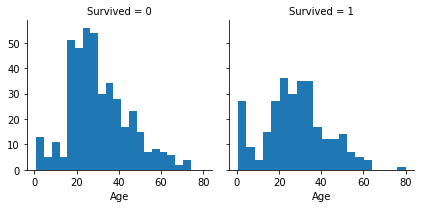

In [10]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## 分析数值型和序数特征

在一张图中分析多类别特征的相关性。

### Observations
1. Pclass=3的乘客最多，但是大多数都没有存活
2. Pclass=2和Pclass=3的小孩大多数都存活
3. Pclass=1的乘客大多存活
4. Pclass在乘客的年龄分布方面各不相同。

### Decisions
把Pclass加入到模型中

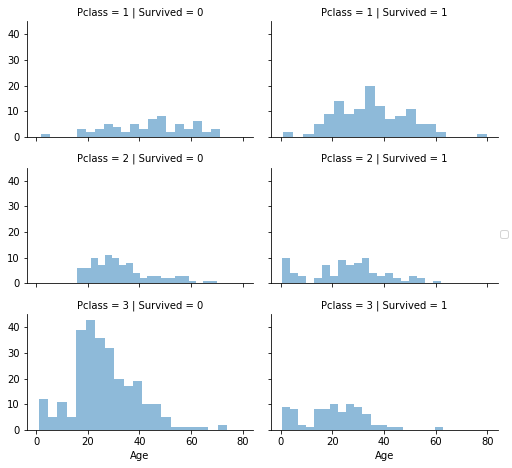

In [11]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## 类别特征的相关性
分析类别特征和存活目标的相关性

### Observations
1. Female乘客的存活率比males高
2. 其中Embarked=C是一个例外，male有更高的存活率。这可能是Pclass和Embarked之间的相关性，反过来也是Pclass和Survived，并不一定是直接相关的
3. C和Q上船的Pclass=3中male存活率更高
4. 在Pclass=3的male中，不同上船口的存活率不同

### Decisions
1. 把Sex加入模型中
2. 补全并把Embarked加入到模型中

/usr/lib/python2.7/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/lib/python2.7/site-packages/seaborn/axisgrid.py:708: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


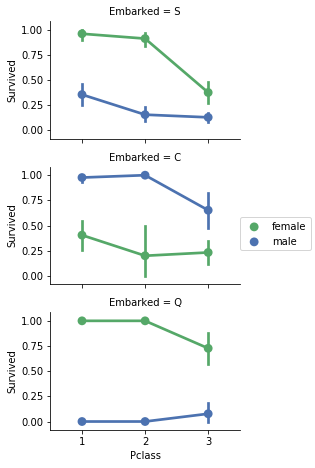

In [12]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## 类别和数值型特征的相关性
分析类别特征和数值型特征的相关性。包括Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric)

### Observations
1. fare越高存活率越高
2. 上船口和存活率相关

### Decisions
1. 把fare划分区间加入模型中

/usr/lib/python2.7/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


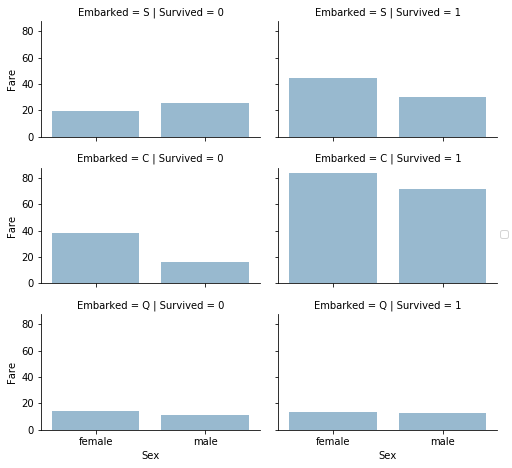

In [13]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# 处理数据

- 根据前面的假设用删除特征的方法对数据集进行纠错构造补全处理。
- 删除特征可以减少需要处理的数据量，加快分析。
- 根据假设和决策，删除Cabin和Ticket
- 注意保持训练集和测试集的一致性

In [14]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

('Before', (891, 12), (418, 11), (891, 12), (418, 11))
('After', (891, 10), (418, 9), (891, 10), (418, 9))


## 从现有的特征中构建新特征
在删除Name和PassengerId特征之前，抽取头衔titles特征，并测试其和存活特征之间的相关性

使用正则表达式抽取titles。正则模式匹配**(\w+\.)**，以一个大写字母开头，点结尾的子字符串。expand=False表示返回一个DataFrame

### Observations
1. 大多数头衔准确对应年龄区间，比如说Master对应平均5岁
2. 不同头衔的Age存活率相差不大
3. 有些头衔大多数都存活(Mme, Lady, Sir)，有些大多数都死亡(Don, Rev, Jonkheer)

### Decision
1. 把Title加入到模型中

In [15]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

# 把一些出现次数少的title集合到一起，命名为rare
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# 把类别特征转化为序数
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


#### 删除Name和PassagerId特征

In [16]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

## 转化类别特征
- 因为很多算法要求，把一些字符型的特征转化为数值型的值。
- 把Sex进行转化，female=1，male=0

In [17]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


## 补全连续数值型特征

首先补全Age特征

可选方法：
1. 用同均值方差的随机数补全
2. 用其他相关的特征（Age, Gender, and Pclass）进行分类，然后取中位数进行补全
3. 综合1和2，先分类，然后取均值方差随机数进行补全

- 1和3会带来新的噪声，所以选择2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


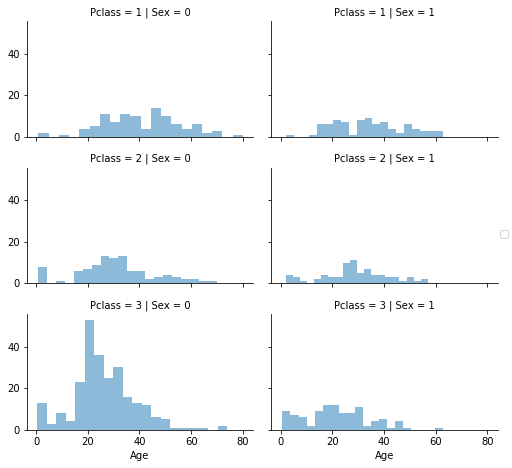

In [18]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

guess_ages = np.zeros((2,3))
for dataset in combine:
    # 计算中位数
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
    
    # 补全
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

### 对Age进行区间划分

In [19]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

# 区间数据转化
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

# 移除AgeBand特征
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


## 通过现有特征构造新特征
- 通过子女和配偶数量（Parch and SibSp）构造家庭成员数量特征

In [20]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


- 构造另外一个特征IsAlone

In [21]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


- 移除旧特征

In [22]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


- 构造新特征Age*Class

In [23]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


## 补全类别特征
Embarked有三个值，用出现最频繁的S进行补全

In [24]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


# 把类别特征转化为数值型
Embarked特征进行简单映射

In [25]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


## 补全和类型转换
- 用中位数补全测试集中的Fare特征
- 对Fare进行区间划分

In [26]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

## 数据处理的结果

In [27]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [28]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


# 模型训练预测解决问题

现在我们用特定的方法来训练预测。有60多种模型算法可供选择。需要根据问题所需来挑选合适的模型。我们的问题是分类回归问题，需要识别输出（是否存活）和其他特征（性别、年龄、登船口等）的关系。可以用有监督的机器学习方法。属于两个范畴 - 有监督学习和分类回归。列出了下面一些方法：

1. Logistic Regression
2. KNN or k-Nearest Neighbors
3. Support Vector Machines
4. Naive Bayes classifier
5. Decision Tree
6. Random Forrest
7. Perceptron
8. Artificial neural network
9. RVM or Relevance Vector Machine

In [29]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

## Logistic Regression
逻辑回归是在工作流早期运行的有用模型。 逻辑回归通过使用逻辑函数估计概率来衡量分类因变量（特征）与一个或多个独立变量（特征）之间的关系，其是累积逻辑分布

- 训练集和评价集是同一个

In [30]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

使用Logistic Regression来验证特征构造和补全的假设和据测，通过计算决策函数的特征相关系数来验证。

正系数提高了响应的对数几率（从而增加了概率），负系数降低了响应的对数几率（从而降低了概率）。

1. Sex的正系数最高，意味着Sex的值从0到1，Survived增加到1的概率最多
2. Pclass增加，Survived存活的概率减少的越多
3. Age*Class特征是负相关第二大的特征
4. Title是正相关第二大的特征

In [31]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287163
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311200
0,Pclass,-0.749007


## Support Vector Machines

一个二分类分类器，具有相关学习算法的监督学习模型，用于分析用于分类和回归分析，从分数上看比逻辑回归效果好

In [32]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.84

## KNN
用于分类和回归的非参数方法。样本的预测结果根据与它相近的邻居点投票决定，样本被分配给其k个最近邻居中最常见的类别（k是正整数，通常较小）。 如果k = 1，则将对象简单地分配给该单个最近邻的类。效果比逻辑回归好，比SVM差

In [33]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

## Naive Bayes classifier
机器学习中一个简单的概率分类器，基于贝叶斯定理和特征之间的独立性假设。具有很高的可扩展性，需要一系列参数在学习问题中的变量数量（特征）的线性关系。目前为止分数最低的一个。

In [34]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

## perceptron 
用于二进制分类器的监督学习的算法（可以决定由数字向量表示的输入是否属于某个特定类别的函数）。 它是一种线性分类器，即基于将权重集合与特征向量组合的线性预测函数进行预测的分类算法。 该算法允许在线学习，因为它一次处理训练集中的元素。

In [35]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


78.0

In [36]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.12

In [37]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


74.64

## Decision Tree
使用决策树作为将特征（树枝）映射到关于目标值（树叶）的结论的预测模型。 目标变量可以采用一组有限值的树模型称为分类树; 在这些树结构中，叶表示类标签，分支表示导致这些类标签的特征的连接。 目标变量可以采用连续值（通常为实数）的决策树称为回归树。目前为止分数最高的。

In [38]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

## Random Forest
最受欢迎的模型之一。随机森林或随机决策树是一种用于分类，回归和其他任务的综合学习方法，通过在训练时间内构建多个决策树（n_estimators = 100）并输出作为类（分类）模式的类， 或平均预测（回归）。目前为止最好的模型，用于输出。

In [39]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

## 模型结果汇总

In [40]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
0,Support Vector Machines,83.84
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.00
6,Stochastic Gradient Decent,74.64
4,Naive Bayes,72.28


## 结果保存

In [41]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)